# Redes Neurais - Projeto 3
# Modelos Generativos - Autoencoders Variacionais
---------------------
### Luis Filipe Menezes
#### RA: 164924

## 1. Objetivos:
Este caderno consiste na terceira entrega da disciplina de Redes Neurais realizada no programa de Pós Graduação em Ciência da Computação durante meu mestrado.

O projeto tem como objetivo:

- Selecionar 2 datasets (rotulados)

  - Treinar modelos VAEs:
  
  - Ajustar o melhor modelo (topologia) segundo a função de custo (conjunto validação)


- Explorar o espaço latente:

  - Gerar gráficos com a projeção do espaço latente em 2D (PCA)

  - Usar os rótulos na projeção.

- Algumas questões:

  1. Há formação de clusters no espaço latente?
  
  2. Há separação dos rótulos no espaço latente?
  
  3. A projeção ilustra quanto da variância?



### Bibliotecas utilizadas:

In [1]:
!pip install --quiet pytorch_lightning

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 831.6/831.6 kB 17.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.2/983.2 kB 48.4 MB/s eta 0:00:00


In [2]:
from torchvision.datasets import FashionMNIST
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import pytorch_lightning as pl
from torch.utils.data import DataLoader
from torchvision import transforms

## Setup do sistema para garantir reprodutibilidade

In [4]:
pl.seed_everything(24)

INFO:lightning_fabric.utilities.seed:Seed set to 24


24

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [117]:
NUM_EPOCHS = 50
BATCH_SIZE = 256
LEARNING_RATE = 1e-3
LATENT_DIM = 50
INPUT_DIM = 28 * 28

## Dataset utilizado (Fashion MNIST)

A função ``transform`` já normaliza o conjunto de dados entre 0 e 1 (como um MinMaxScaler).
Será utilizado a divisão 60/20/20 para treino/validação/teste.

In [5]:
transform = transforms.Compose([transforms.ToTensor()])

train_dataset = FashionMNIST(root='./FMNIST_data', train=True, download=True, transform=transform)


100%|██████████| 26.4M/26.4M [00:01<00:00, 14.4MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 211kB/s]
100%|██████████| 4.42M/4.42M [00:01<00:00, 3.93MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 28.9MB/s]


In [6]:
test_dataset = FashionMNIST(root='./FMNIST_data', train=False, download=True, transform=transform)

In [7]:
train_set, val_set = torch.utils.data.random_split(train_dataset, [45000, 15000]) # 60 / 20 / 20


In [48]:
train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True, drop_last=True, pin_memory=True, num_workers=2)
val_loader = DataLoader(val_set, batch_size=BATCH_SIZE, shuffle=True, drop_last=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True, drop_last=False, num_workers=2)

In [49]:
from torchvision.utils import save_image
import os

# utility functions
def get_device():
    if torch.cuda.is_available():
        device = 'cuda:0'
    else:
        device = 'cpu'
    return device
def make_dir():
    image_dir = 'FashionMNIST_Images'
    if not os.path.exists(image_dir):
        os.makedirs(image_dir)

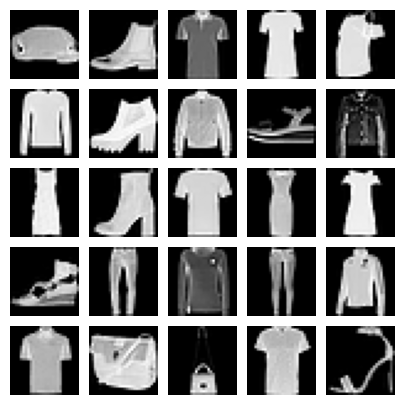

In [50]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid

dataiter = iter(train_loader)
image = next(dataiter)

num_samples = 25
sample_images = [image[0][i,0] for i in range(num_samples)]

fig = plt.figure(figsize=(5, 5))
grid = ImageGrid(fig, 111, nrows_ncols=(5, 5), axes_pad=0.1)

for ax, im in zip(grid, sample_images):
    ax.imshow(im, cmap='gray')
    ax.axis('off')

plt.show()

## Modelo em PyTorch

A arquitetura na qual esse VAE foi baseada utiliza apenas

In [159]:
import torch
import torch.nn as nn

class VAE(nn.Module):
    def __init__(self, input_dim=784, hidden_dim1=400, hidden_dim2=300, latent_dim=50):
        super(VAE, self).__init__()

        # Encoder: Reduz até hidden_dim2 (2x)
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dim1),
            nn.ReLU(),
            nn.Linear(hidden_dim1, hidden_dim2),
            nn.ReLU(),
            nn.Linear(hidden_dim2, hidden_dim2),
            nn.ReLU()
        )

        # Latent mean and variance (Ramificam da última camada oculta)
        self.mean_layer = nn.Linear(hidden_dim2, latent_dim)
        self.logvar_layer = nn.Linear(hidden_dim2, latent_dim)

        # Decoder: Espelha o encoder
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, hidden_dim2),
            nn.ReLU(),
            nn.Linear(hidden_dim2, hidden_dim2),
            nn.ReLU(),
            nn.Linear(hidden_dim2, hidden_dim1),
            nn.ReLU(),
            nn.Linear(hidden_dim1, input_dim),
            # nn.Sigmoid() # Garante saída entre 0 e 1 (para imagens normalizadas) Tirei o sigmoid pois não estamos utilizando mais cross entropy
        )

    def encode(self, x):
        # Passa pelo corpo do encoder
        h = self.encoder(x)
        # Projeta para média e log-variância
        mean = self.mean_layer(h)
        logvar = self.logvar_layer(h)
        return mean, logvar

    def reparameterization(self, mean, std):
        epsilon = torch.randn_like(std).to(std.device)
        z = mean + std * epsilon
        return z

    def decode(self, z):
        return self.decoder(z)

    def forward(self, x):
        mean, log_var = self.encode(x)
        # Conversão correta de log_var para desvio padrão (std)
        std = torch.exp(0.5 * log_var)
        z = self.reparameterization(mean, std)
        x_hat = self.decode(z)
        return x_hat, mean, log_var

In [161]:
def loss_function(x, x_hat, mean, log_var):
    reproduction_loss = nn.functional.mse_loss(x_hat, x, reduction='sum')

    KLD = - 0.5 * torch.sum(1 + log_var - mean.pow(2) - log_var.exp())
    # Estou dividindo o KLD pela metade para que ele não lidere o ajuste dos pesos, queremos um modelo com reconstrução aceitável e uma boa distribuição do espaço latente
    return reproduction_loss + 0.5* KLD

In [162]:
import torch

def train(model, optimizer, epochs, device, train_loader, val_loader, x_dim=784):
    # Listas para guardar histórico (opcional, bom para plotar gráficos depois)
    history_train = []
    history_val = []

    for epoch in range(epochs):
        # 1. LOOP DE TREINAMENTO
        model.train() # Garante que dropout/batchnorm funcionem
        train_loss = 0

        for batch_idx, (x, _) in enumerate(train_loader):
            # Use x.size(0) em vez de BATCH_SIZE fixo para evitar crash no último batch
            x = x.view(x.size(0), x_dim).to(device)

            optimizer.zero_grad()

            x_hat, mean, log_var = model(x)
            loss = loss_function(x, x_hat, mean, log_var)

            loss.backward()
            optimizer.step()

            train_loss += loss.item()

        # 2. LOOP DE VALIDAÇÃO
        model.eval()
        val_loss = 0

        with torch.no_grad(): # Economiza memória e cálculo
            for batch_idx, (x, _) in enumerate(val_loader):
                x = x.view(x.size(0), x_dim).to(device)

                x_hat, mean, log_var = model(x)
                loss = loss_function(x, x_hat, mean, log_var)

                val_loss += loss.item()


        avg_train_loss = train_loss / len(train_loader.dataset)
        avg_val_loss = val_loss / len(val_loader.dataset)

        history_train.append(avg_train_loss)
        history_val.append(avg_val_loss)

        print(f"Epoch {epoch+1}/{epochs} | Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f}")

    return model, history_train, history_val

## Treinamento do modelo:

A arquitetura que melhor respondeu aos ajustes de hiperparâmetros foi:

- 3 camadas ocultas de 600, 200 e 200 neurônios em um espaço latente de 50.
- De taxa de aprendizado foi utilizado 0.001.


In [163]:
model = VAE(input_dim=784, hidden_dim1=600, hidden_dim2=200, latent_dim=LATENT_DIM).to(device)
from torch.optim import Adam
optimizer = Adam(model.parameters(), lr=LEARNING_RATE)

In [164]:
model, history_train, history_val = train(model, optimizer, NUM_EPOCHS, device, train_loader, val_loader)

Epoch 1/50 | Train Loss: 44.5295 | Val Loss: 32.2180
Epoch 2/50 | Train Loss: 29.3432 | Val Loss: 27.4470
Epoch 3/50 | Train Loss: 26.3304 | Val Loss: 25.0981
Epoch 4/50 | Train Loss: 24.5194 | Val Loss: 23.7288
Epoch 5/50 | Train Loss: 23.4503 | Val Loss: 23.3649
Epoch 6/50 | Train Loss: 22.8589 | Val Loss: 22.4390
Epoch 7/50 | Train Loss: 22.3608 | Val Loss: 22.0832
Epoch 8/50 | Train Loss: 22.0225 | Val Loss: 21.8429
Epoch 9/50 | Train Loss: 21.6400 | Val Loss: 21.3935
Epoch 10/50 | Train Loss: 21.2632 | Val Loss: 21.0638
Epoch 11/50 | Train Loss: 21.0229 | Val Loss: 20.8472
Epoch 12/50 | Train Loss: 20.8692 | Val Loss: 20.6776
Epoch 13/50 | Train Loss: 20.7067 | Val Loss: 20.5354
Epoch 14/50 | Train Loss: 20.5796 | Val Loss: 20.8086
Epoch 15/50 | Train Loss: 20.4687 | Val Loss: 20.4851
Epoch 16/50 | Train Loss: 20.3811 | Val Loss: 20.4547
Epoch 17/50 | Train Loss: 20.2719 | Val Loss: 20.3692
Epoch 18/50 | Train Loss: 20.2139 | Val Loss: 20.4293
Epoch 19/50 | Train Loss: 20.1572 | V

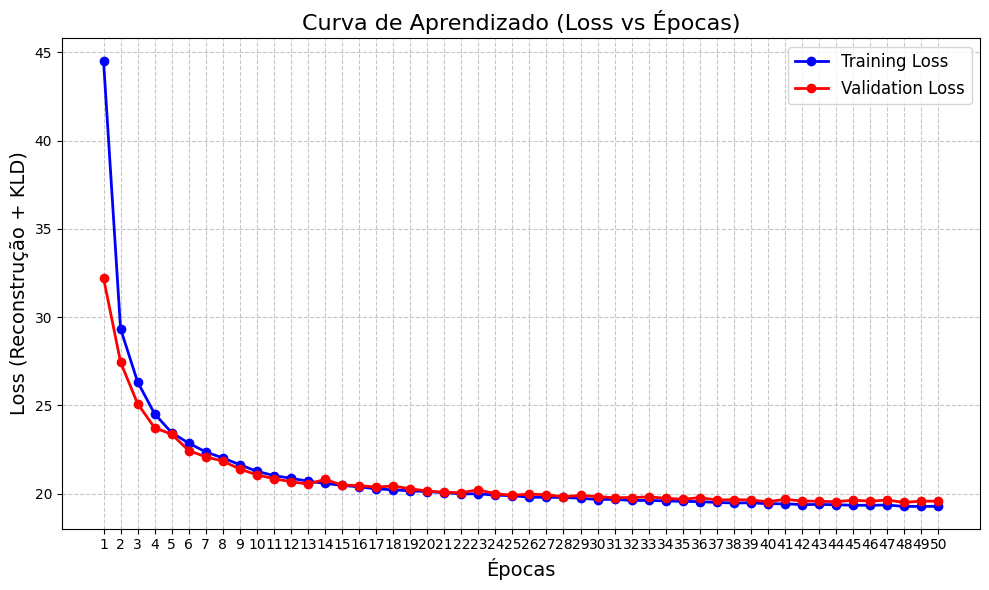

In [165]:
import matplotlib.pyplot as plt

def plot_learning_curve(train_losses, val_losses):
    """
    Plota a curva de aprendizado comparando treino e validação.

    Args:
        train_losses (list): Lista com os valores de loss de treino por época.
        val_losses (list): Lista com os valores de loss de validação por época.
    """
    epochs = range(1, len(train_losses) + 1)

    plt.figure(figsize=(10, 6))

    # Plotando Treino
    plt.plot(epochs, train_losses, 'b-o', label='Training Loss', linewidth=2)

    # Plotando Validação
    plt.plot(epochs, val_losses, 'r-o', label='Validation Loss', linewidth=2)

    plt.title('Curva de Aprendizado (Loss vs Épocas)', fontsize=16)
    plt.xlabel('Épocas', fontsize=14)
    plt.ylabel('Loss (Reconstrução + KLD)', fontsize=14)

    plt.legend(fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.7)

    # Garante que o eixo X mostre apenas números inteiros
    plt.xticks(epochs)

    plt.tight_layout()
    plt.show()

plot_learning_curve(history_train, history_val)

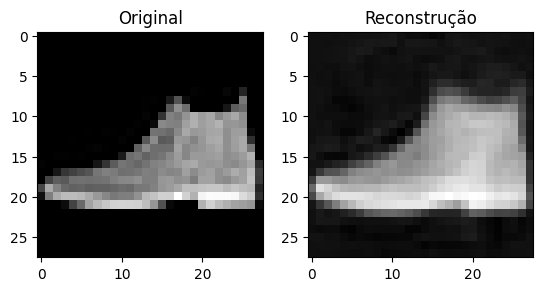

In [166]:
import matplotlib.pyplot as plt

def visualize_reconstruction(model, dataset, device):
    model.eval()
    # Pega uma imagem do dataset
    x, _ = dataset[0]
    x = x.unsqueeze(0).to(device).view(1, 784) # Prepara para o modelo

    with torch.no_grad():
        x_hat, _, _ = model(x)

    # Desnormaliza visualmente (apenas reshape)
    orig = x.view(28, 28).cpu()
    recon = x_hat.view(28, 28).cpu()

    fig, ax = plt.subplots(1, 2)
    ax[0].imshow(orig, cmap='gray')
    ax[0].set_title("Original")
    ax[1].imshow(recon, cmap='gray')
    ax[1].set_title(f"Reconstrução")
    plt.show()

# Chame isso após o treino
visualize_reconstruction(model, test_dataset, device)

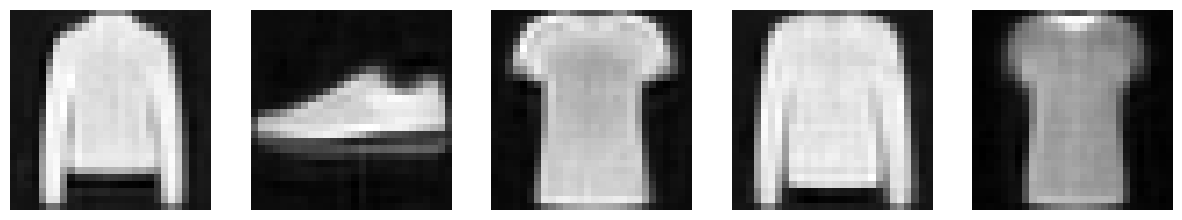

In [167]:
def generate_new_samples(model, device, latent_dim=100, num_samples=5):
    model.eval()
    with torch.no_grad():
        # 1. Gera ruído aleatório da distribuição Normal(0, 1)
        z = torch.randn(num_samples, latent_dim).to(device)

        # 2. Decodifica
        samples = model.decode(z).cpu()

    # 3. Plota
    plt.figure(figsize=(15, 3))
    for i in range(num_samples):
        plt.subplot(1, num_samples, i+1)
        plt.imshow(samples[i].view(28, 28), cmap='gray')
        plt.axis('off')
        plt.title("")
    plt.show()

generate_new_samples(model, device, latent_dim=LATENT_DIM)

## Análise do espaço latente

In [171]:
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import torch

# Dicionário para traduzir os números em nomes reais
fashion_classes = {
    0: 'T-shirt/top', 1: 'Trouser', 2: 'Pullover', 3: 'Dress', 4: 'Coat',
    5: 'Sandal', 6: 'Shirt', 7: 'Sneaker', 8: 'Bag', 9: 'Ankle boot'
}

def get_latent_vectors(model, loader, device):
    model.eval()
    latent_vectors = []
    labels = []

    with torch.no_grad():
        for x, y in loader:
            x = x.view(x.size(0), -1).to(device)

            # Usamos apenas a média (mean) pois é o centroide da distribuição
            mean, _ = model.encode(x)

            latent_vectors.append(mean.cpu().numpy())
            labels.append(y.numpy())

    # Concatena tudo em um único array numpy gigante
    latent_vectors = np.concatenate(latent_vectors, axis=0)
    labels = np.concatenate(labels, axis=0)

    return latent_vectors, labels

# Executando a extração (Use seu val_loader ou test_loader)
# Certifique-se de que 'val_loader' está definido
print("Extraindo vetores latentes...")
z_points, z_labels = get_latent_vectors(model, test_loader, device)
print(f"Formato dos dados extraídos: {z_points.shape}") # Deve ser (N_amostras, LATENT_DIM)

Extraindo vetores latentes...
Formato dos dados extraídos: (10000, 50)


Calculando PCA...


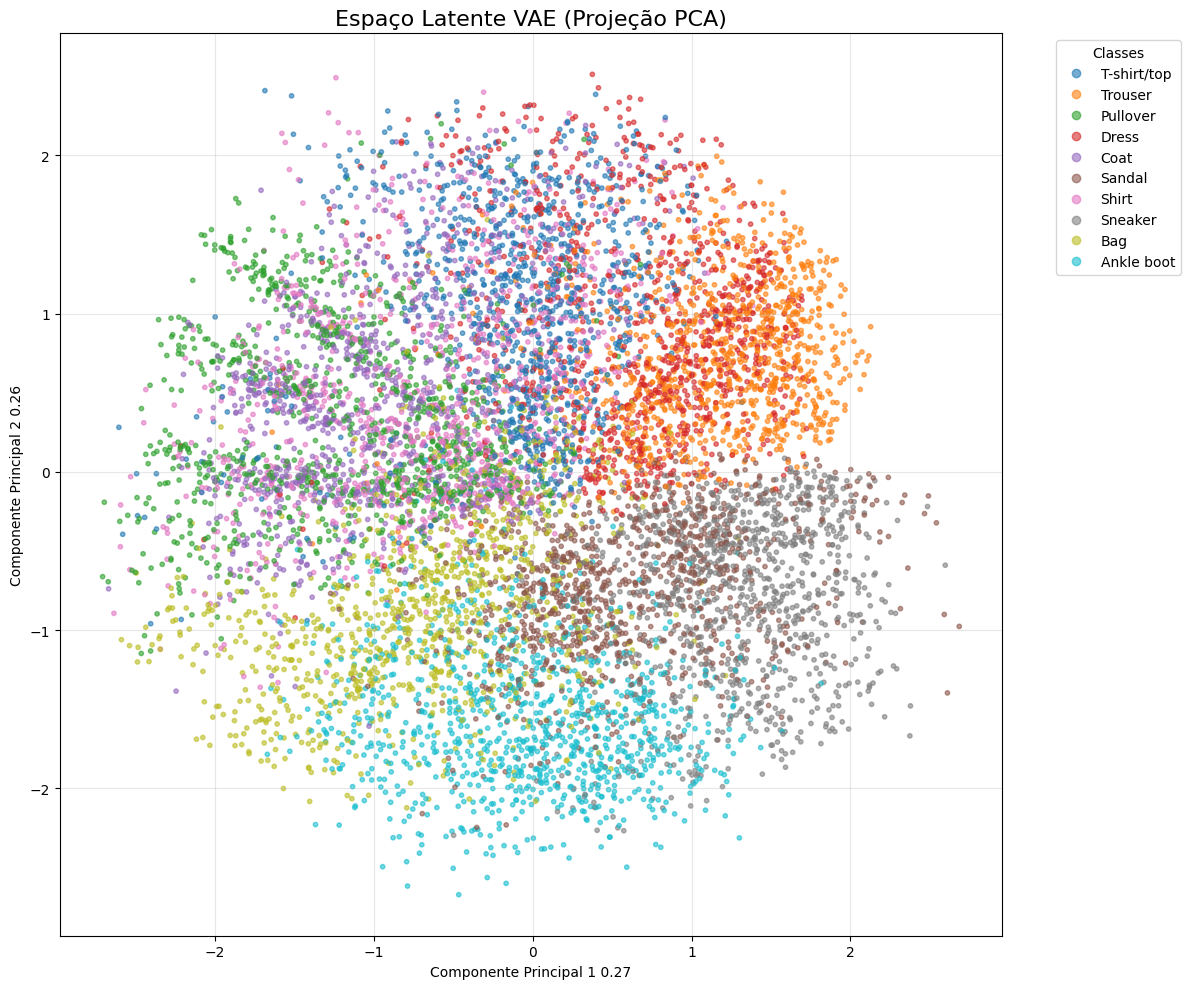

In [172]:
def plot_latent_space_pca(z_points, z_labels):
    print("Calculando PCA...")
    # Reduz de 100 dimensões para 2
    pca = PCA(n_components=2)
    z_2d = pca.fit_transform(z_points)

    plt.figure(figsize=(12, 10))

    # Cria um scatter plot colorido por classe
    scatter = plt.scatter(z_2d[:, 0], z_2d[:, 1], c=z_labels, cmap='tab10', alpha=0.6, s=10)

    # Cria a legenda com os nomes reais das roupas
    handles, _ = scatter.legend_elements()
    legend_labels = [fashion_classes[i] for i in range(10)]
    plt.legend(handles, legend_labels, title="Classes", bbox_to_anchor=(1.05, 1), loc='upper left')

    plt.title('Espaço Latente VAE (Projeção PCA)', fontsize=16)
    plt.xlabel(f'Componente Principal 1 ({pca.explained_variance_ratio_[0]: .2f})')
    plt.ylabel(f'Componente Principal 2({pca.explained_variance_ratio_[1]: .2f})')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

# Gerar o gráfico
plot_latent_space_pca(z_points, z_labels)

## Comentários e conclusões

A PCA mantém 53% da variância dos dados originais, o que nos dá uma boa representação do espaço latente.

Acerca da distribuição, é possível ver uma geração de *clusters*  "axiais", isto é, partindo da origem (0,0), é possível ver a formação de *clusters* levemente definidos. Um exemplo claro é para a classe "*trouser*" que é expressa como uma região densa no canto superior direito.

Há uma separação do espaço latente, mas com certas ressalvas. Há um agrupamento "semântico" onde objetos que possuem funcionalidades parecidas estão em regiões próximas (ex.: Calçados todos agrupados na parte de baixo do gráfico). O modelo aprendeu que "coisas de por no pé" são parecidas entre si e diferentes de roupas de corpo.
Há uma certa sobreposição, onde visualmente, um Pullover e um Coat estão misturados, isso se dá porque numa resolução 28x28, ambos são muito parecidos (ambos têm mangas e cobrem o tronco).